In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Data

In [0]:
path_train = '/content/drive/My Drive/Data/kaggle/rsna2019/rsna2019/4500_256/valid/'
path_valid = '/content/drive/My Drive/Data/kaggle/rsna2019/rsna2019/4500_256/100/'
batch_size = 50

In [0]:
trainset = torchvision.datasets.ImageFolder(root = path_train,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((224,224)),
                                                                                          transforms.ToTensor()]))
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((224,224)),
                                                                                          transforms.ToTensor()]))
train_iter = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
valid_iter = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=True)

In [6]:
tgtnames = trainset.classes
tgtnames

['normal', 'not_normal', 'opacity']

In [7]:
validset

Dataset ImageFolder
    Number of datapoints: 300
    Root location: /content/drive/My Drive/Data/kaggle/rsna2019/rsna2019/4500_256/100/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

## Architecture: GoogLeNet

In [0]:
# setting hyper-parameters
learning_rate = 0.05
num_epochs = 80
num_workers = 0


In [0]:
class Inception(nn.Module):
    # c1 - c4 are the number of output channels for each layer in the path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

In [0]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [0]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [0]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                    Inception(256, 128, (128, 192), (32, 96), 64),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [0]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [14]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveMaxPool2d((1,1)),
                   Flatten())

googlenet = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 3))
googlenet

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (p4_2): Conv2d(192, 32, kernel_size=(1, 1),

In [0]:
#Initialization of Weights
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
googlenet.apply(init_weights)
googlenet = googlenet.to(device)


# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(googlenet.parameters(),lr=learning_rate) # sgd

## Train Network

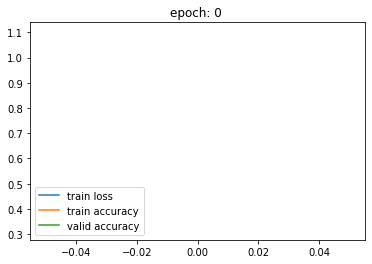

train loss:  1.1004430135091146
train accuracy:  0.3166666626930237
valid accuracy:  0.3333333432674408


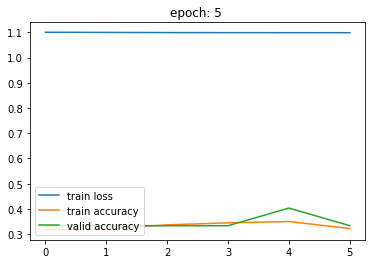

train loss:  1.09866574605306
train accuracy:  0.32199999690055847
valid accuracy:  0.3333333432674408


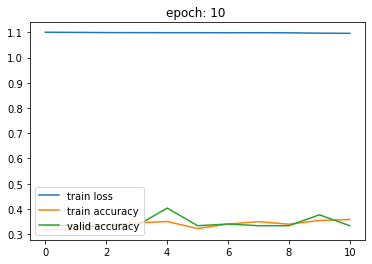

train loss:  1.0961302439371745
train accuracy:  0.3580000102519989
valid accuracy:  0.3333333432674408


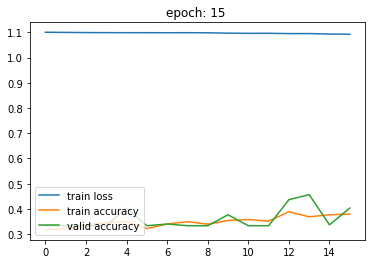

train loss:  1.092379633585612
train accuracy:  0.37933334708213806
valid accuracy:  0.4033333361148834


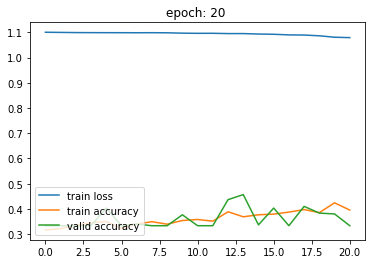

train loss:  1.0790934244791666
train accuracy:  0.39533331990242004
valid accuracy:  0.3333333432674408


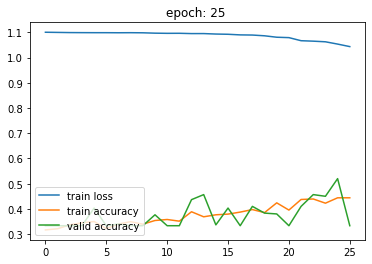

train loss:  1.0435198465983073
train accuracy:  0.4440000057220459
valid accuracy:  0.3333333432674408


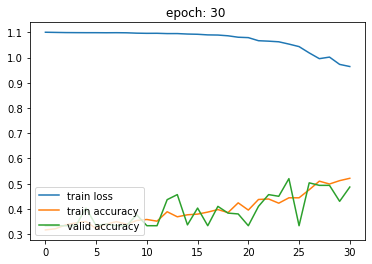

train loss:  0.964535903930664
train accuracy:  0.5213333368301392
valid accuracy:  0.4866666793823242


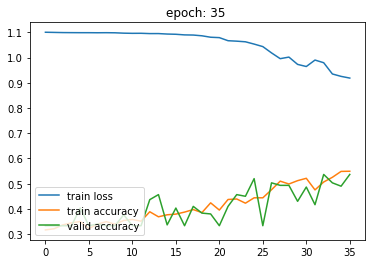

train loss:  0.9187184015909831
train accuracy:  0.5493333339691162
valid accuracy:  0.5366666913032532


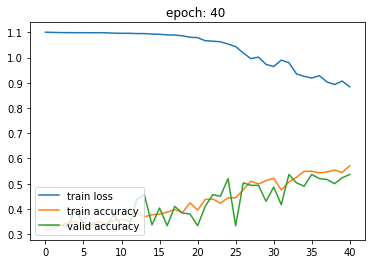

train loss:  0.8840154012044271
train accuracy:  0.5713333487510681
valid accuracy:  0.5366666913032532


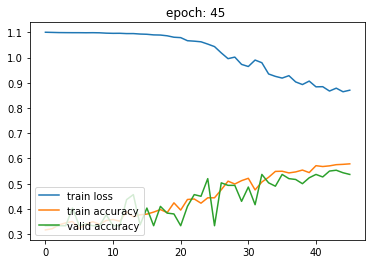

train loss:  0.8706536610921224
train accuracy:  0.5786666870117188
valid accuracy:  0.5366666913032532


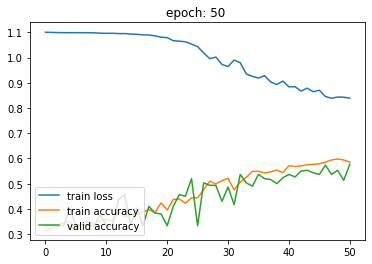

train loss:  0.838932991027832
train accuracy:  0.5853333473205566
valid accuracy:  0.5766666531562805


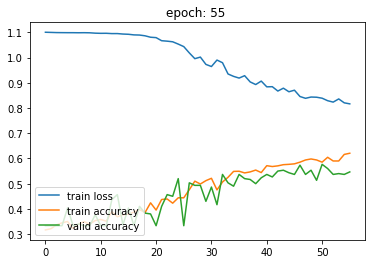

train loss:  0.81648743947347
train accuracy:  0.6206666827201843
valid accuracy:  0.54666668176651


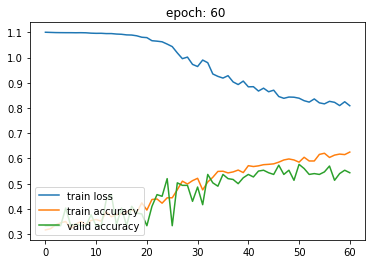

train loss:  0.8091013590494792
train accuracy:  0.625333309173584
valid accuracy:  0.5433333516120911


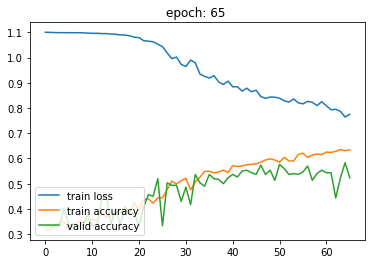

train loss:  0.7752005259195963
train accuracy:  0.6340000033378601
valid accuracy:  0.5233333110809326


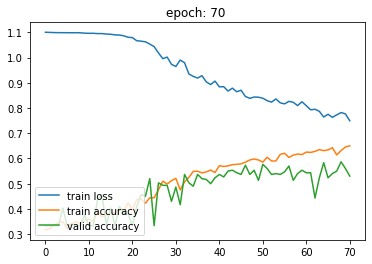

train loss:  0.7495363871256511
train accuracy:  0.6499999761581421
valid accuracy:  0.5299999713897705


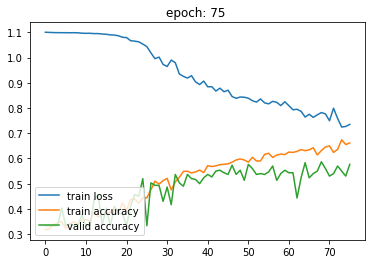

train loss:  0.7349926630655924
train accuracy:  0.6613333225250244
valid accuracy:  0.5766666531562805


In [16]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  googlenet.train()
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device)
    y_hat=googlenet(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()  

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset)))

  correct = 0
  googlenet.eval()
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = googlenet(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset)))


  if epoch%5 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])

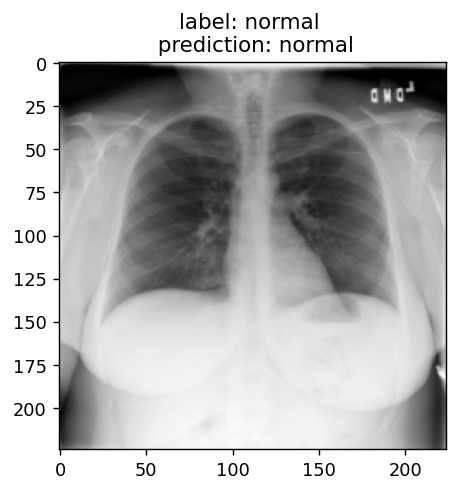

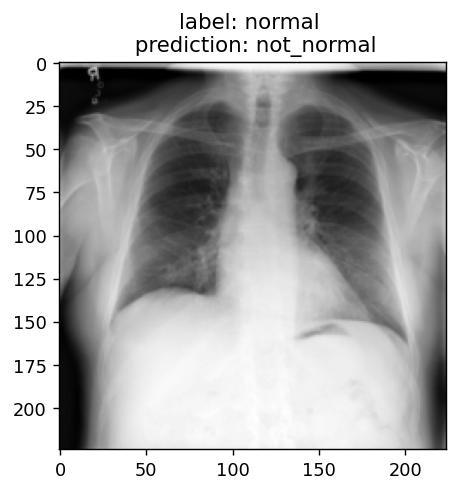

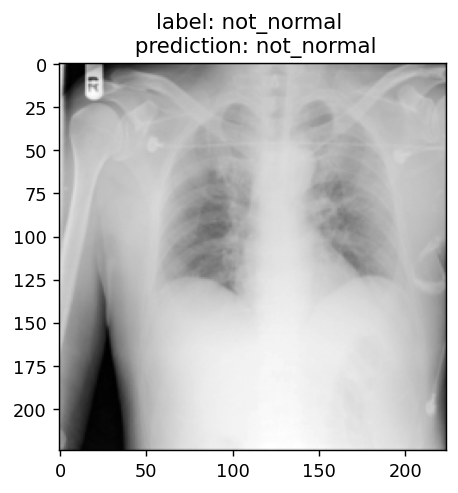

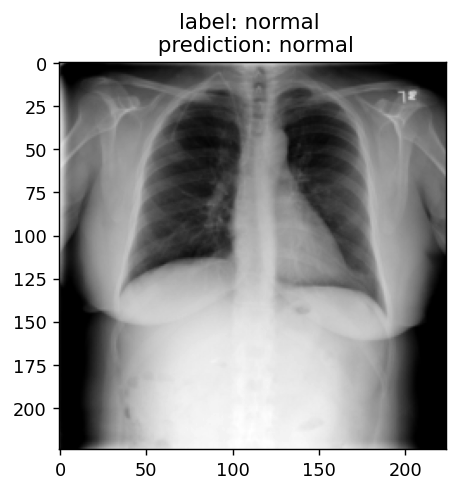

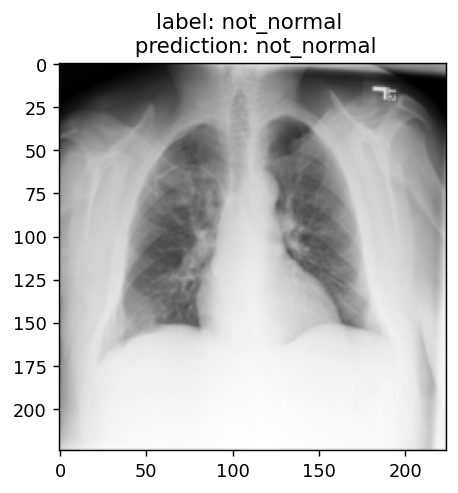

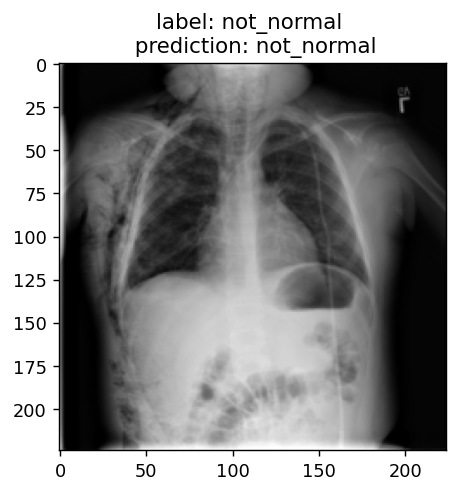

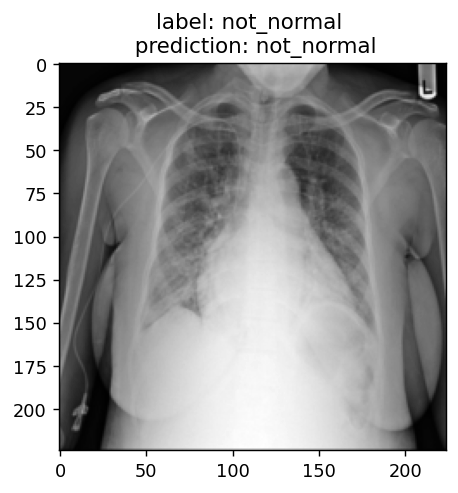

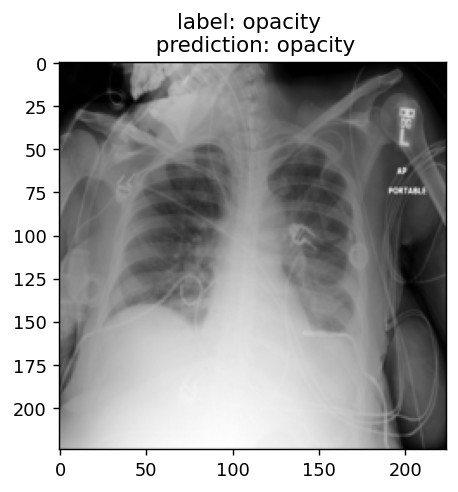

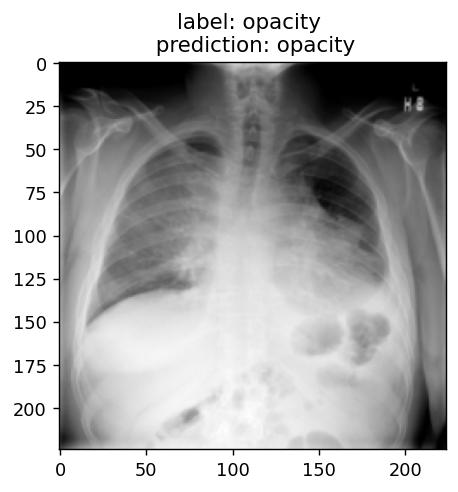

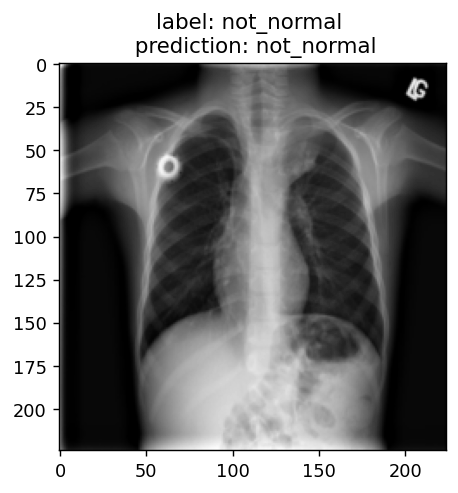

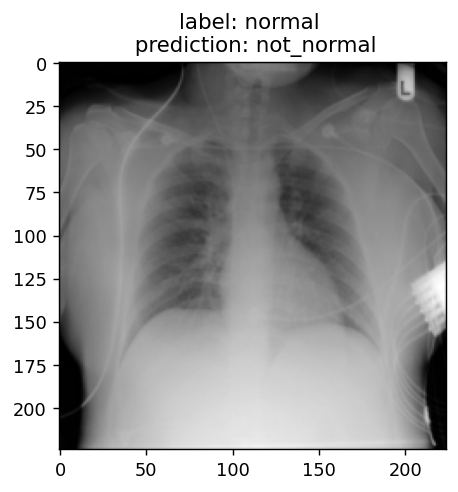

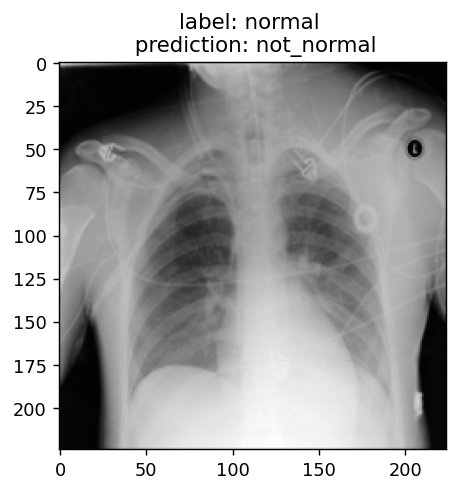

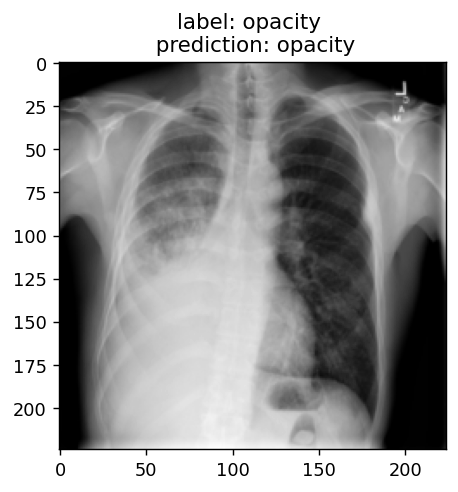

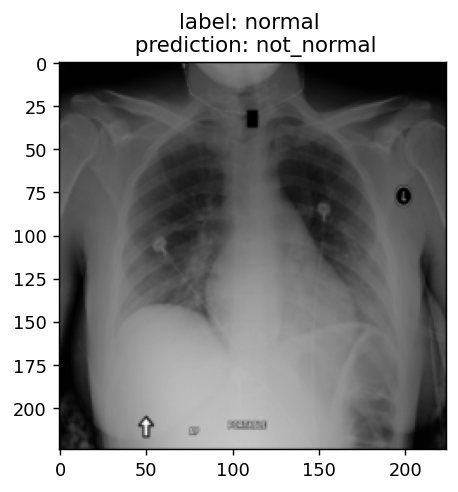

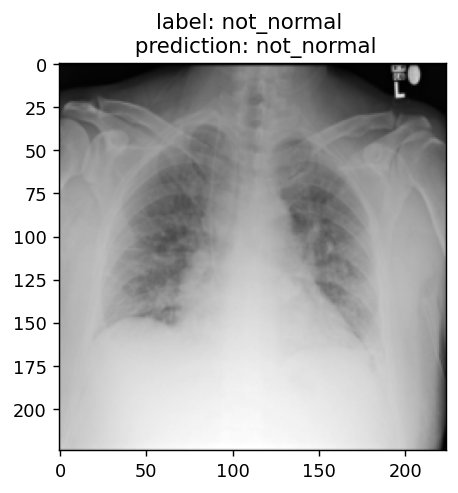

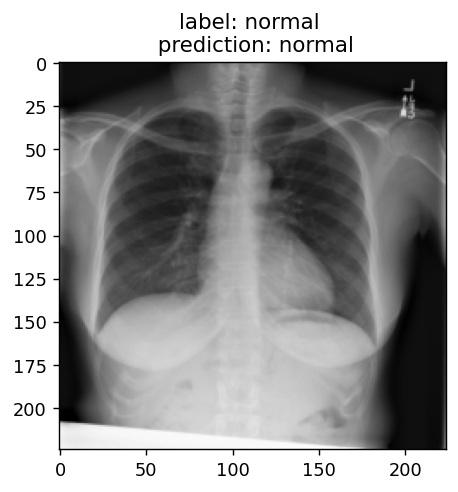

In [20]:
i = 0
googlenet.eval()
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = googlenet(X)    
  y_hat = y_hat.argmax(dim=1)
  for n in range(8):
    plt.figure(dpi=128)
    plt.imshow(X[n].cpu().squeeze(),cmap='gray')
    plt.title('label: %s \n prediction: %s'%(tgtnames[y[n]],tgtnames[y_hat[n]]))
    plt.pause(.0001)
  if i>1:
     break